### Customer Segmentation
        Customers have their own needs and different profile. 
    If we want to increase the retention rate , we can do segmentation based on churn probability.
    Here we can use RFM method for customer Segmentation.
    
    RFM-- Recency - Frequency - Monetory value
    . Low Value:- customers who are less active, not frequent buyers
    . Mid Value:- Customers do purchases moderate.
    . High Value:- Customer who are more valuable and we don't  want to lose. (High Frequency, High Revenue)

Here we are Calculating Recency, Frequency and monetary scores for each customer and applying unsupervised Machine
learning to identify different groups(clusters) for each.

In [22]:
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
tx_data = pd.read_table('C:\\Users\\Raghuram\\Desktop\\project\\000.txt',header=None,sep=",")

tx_data.columns=["date","cust_id","event","price","product_id","category"]
tx_data.head(5)

,date,cust_id,event,price,product_id,category
0,2019-01-14,007e188b-63b2-4c0b-9c74-2eb5a4cb1d9b,addToCart,337,PR923AT55PMADFMX,women>outerwear>vests
1,2019-01-14,007e188b-63b2-4c0b-9c74-2eb5a4cb1d9b,addToCart,337,PR923AT55PMADFMX,women>outerwear>vests
2,2019-01-14,007e188b-63b2-4c0b-9c74-2eb5a4cb1d9b,addToCart,337,PR923AT09IUWDFMX,women>outerwear>vests
3,2019-01-14,007e188b-63b2-4c0b-9c74-2eb5a4cb1d9b,addToCart,117,MA194AT06LOBDFMX,boys>topwear>sweatshirts
4,2019-01-14,007e188b-63b2-4c0b-9c74-2eb5a4cb1d9b,addToCart,117,MA194AT06LOBDFMX,boys>topwear>sweatshirts


In [3]:
tx_data=tx_data.loc[tx_data['event'].isin(['buy'])]
print(tx_data.shape)
tx_data.head()

(9464, 6)


,date,cust_id,event,price,product_id,category
16796,2019-01-18,05fa0274-07ed-424f-9930-9e00a181a57b,buy,1999,TI778SH75SKEDFMX,men>shoes>boots
16797,2019-01-18,05fa0274-07ed-424f-9930-9e00a181a57b,buy,1499,TI778SH87SJSDFMX,men>shoes>boots
16798,2019-01-11,0cbc10e5-005a-4960-a7fb-28931bd82daf,buy,1199,TH934AT94SAVDFMX,women>outerwear>jackets
16799,2019-01-18,1256d1c8-feae-4226-871a-b90e7d918ee0,buy,299,SQ017AT94NEVDFMX,men>activewear>tshirts
16800,2019-01-18,1256d1c8-feae-4226-871a-b90e7d918ee0,buy,299,DO528AB27RRWDFMX,men>bottomwear>shorts


### Recency
   
   Extracting No. of days recently purchased by the customer by subtracting last purchase date of a customer with the maximum date of the total data.

In [28]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
tx_user = pd.DataFrame(tx_data['cust_id'].unique())
tx_user.columns = ['cust_id']

#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = tx_data.groupby('cust_id').date.max().reset_index()
tx_max_purchase.columns = ['cust_id','MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
tx_max_purchase['Recency'] = (pd.to_datetime(tx_max_purchase['MaxPurchaseDate'].max())-pd.to_datetime(tx_max_purchase['MaxPurchaseDate'])).dt.days

#merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['cust_id','Recency']], on='cust_id')

tx_user.head()

,cust_id,Recency
0,05fa0274-07ed-424f-9930-9e00a181a57b,139
1,0cbc10e5-005a-4960-a7fb-28931bd82daf,146
2,1256d1c8-feae-4226-871a-b90e7d918ee0,139
3,16f9603d-50c1-4115-903d-e28660746711,149
4,1b33e61c-8d36-4a31-a50f-0b21c46221cc,153


Below is the distribution of the customers recency 

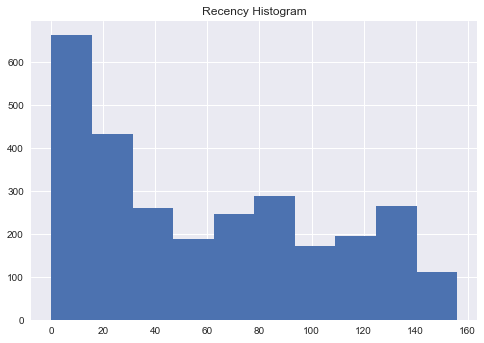

In [29]:
#plot a recency histogram
plt.hist(tx_user['Recency'])
plt.title('Recency Histogram')
plt.show()

In [ ]:
Average recency is 60 and median is 51.

In [31]:
tx_user.Recency.describe()

count    2819.000000
mean       59.638524
std        45.997125
min         0.000000
25%        17.500000
50%        51.000000
75%        98.000000
max       156.000000
Name: Recency, dtype: float64

KMeans custering on Recency measure of customers.
Finding optimal No. of Clusters(groups) by using screeplot. By the Screeplot we found there are 4 possible customer segments from the given data.

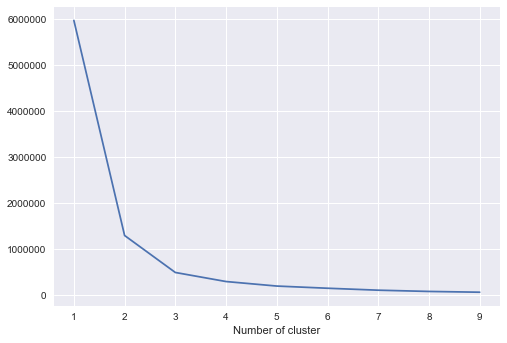

In [33]:

from sklearn.cluster import KMeans
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [34]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [35]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)


In [44]:
(tx_user.groupby('RecencyCluster')['Recency'].describe())

RecencyCluster       
0               count     576.000000
                mean      130.043403
                std        11.417448
                min       109.000000
                25%       121.000000
                50%       131.000000
                75%       136.000000
                max       156.000000
1               count     597.000000
                mean       86.482412
                std        11.387550
                min        68.000000
                25%        78.000000
                50%        85.000000
                75%        95.000000
                max       108.000000
2               count     573.000000
                mean       47.778360
                std        11.676350
                min        31.000000
                25%        37.000000
                50%        47.000000
                75%        58.000000
                max        67.000000
3               count    1073.000000
                mean       13.242311
                

### Frequency

In [45]:
#get order counts for each user and create a dataframe with it
tx_frequency = tx_data.groupby('cust_id').date.count().reset_index()
tx_frequency.columns = ['cust_id','Frequency']

#add this data to our main dataframe
tx_user = pd.merge(tx_user, tx_frequency, on='cust_id')
tx_user.head()

,cust_id,Recency,RecencyCluster,Frequency
0,05fa0274-07ed-424f-9930-9e00a181a57b,139,0,2
1,0cbc10e5-005a-4960-a7fb-28931bd82daf,146,0,1
2,1256d1c8-feae-4226-871a-b90e7d918ee0,139,0,3
3,16f9603d-50c1-4115-903d-e28660746711,149,0,5
4,1b33e61c-8d36-4a31-a50f-0b21c46221cc,153,0,5


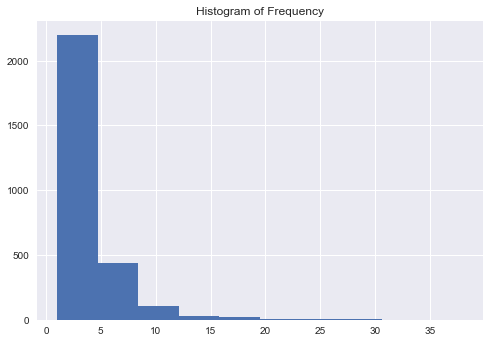

In [52]:
plt.hist(tx_user.loc[tx_user['Frequency']<40,'Frequency'])
plt.title("Histogram of Frequency")
plt.show()


In [53]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#see details of each cluster
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

FrequencyCluster       
0                 count    2198.000000
                  mean        1.876706
                  std         0.999223
                  min         1.000000
                  25%         1.000000
                  50%         2.000000
                  75%         2.000000
                  max         4.000000
1                 count     573.000000
                  mean        7.109948
                  std         2.393929
                  min         5.000000
                  25%         5.000000
                  50%         6.000000
                  75%         8.000000
                  max        14.000000
2                 count      46.000000
                  mean       22.304348
                  std         8.134616
                  min        15.000000
                  25%        16.250000
                  50%        19.500000
                  75%        26.000000
                  max        56.000000
3                 count       2.000000
 

### Revenue/Monetary

In [55]:
#calculate revenue for each customer
tx_revenue = tx_data.groupby('cust_id').price.sum().reset_index()

#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='cust_id')


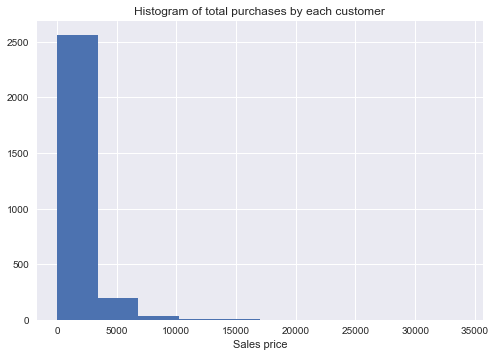

In [59]:
plt.hist(tx_user.loc[tx_user['price']<50000,'price'])
plt.xlabel("Sales price")
plt.title("Histogram of total purchases by each customer")
plt.show()

In [60]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['price']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['price']])


#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'price',tx_user,True)

#show details of the dataframe
tx_user.groupby('RevenueCluster')['price'].describe()

RevenueCluster       
0               count     2309.000000
                mean      1070.484625
                std        576.682407
                min         -1.000000
                25%        583.000000
                50%        999.000000
                75%       1546.000000
                max       2354.000000
1               count      458.000000
                mean      3672.109170
                std       1167.577277
                min       2372.000000
                25%       2703.250000
                50%       3366.500000
                75%       4338.750000
                max       7496.000000
2               count       50.000000
                mean     11479.420000
                std       4909.399756
                min       7695.000000
                25%       8544.750000
                50%       9690.500000
                75%      13190.000000
                max      33991.000000
3               count        2.000000
                mean     654

In [61]:
#calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.groupby('OverallScore')['Recency','Frequency','price'].mean()

,Recency,Frequency,price
OverallScore,,,
0,129.780761,1.736018,1000.711409
1,94.385417,2.342014,1186.595486
2,59.377637,2.523207,1259.466245
3,22.187717,2.668598,1359.974508
4,19.978022,5.622711,2754.307692
5,17.251748,9.041958,4768.769231
6,12.592593,15.074074,7310.296296
7,12.285714,26.142857,15645.642857
8,12.000000,114.000000,33991.000000


The scoring above clearly shows us that customers with score(cluster) 8 is our best customers whereas 0(cluster) 
is the worst.

To keep things simple, better we name these scores:

0 to 2: Low Value

3 to 4: Mid Value

5+: High Value

We can easily apply this naming on our dataframe:

In [63]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [64]:
tx_user.head()

,cust_id,Recency,RecencyCluster,Frequency,FrequencyCluster,price,RevenueCluster,OverallScore,Segment
0,05fa0274-07ed-424f-9930-9e00a181a57b,139,0,2,0,3498,1,1,Low-Value
1,09b272ce-36cd-4be6-838e-5d4766cf508e,133,0,2,0,2998,1,1,Low-Value
2,37cf413f-05e7-4210-be73-e8ac078fc631,133,0,4,0,6796,1,1,Low-Value
3,45a0e0fd-4e34-4be9-b7cf-eba71ceb60e3,133,0,2,0,3498,1,1,Low-Value
4,683bed1e-1a89-434c-b359-7a6bc2861536,133,0,2,0,3398,1,1,Low-Value


### scatter plots for each pair of RFM Clusters
We can start taking actions with this segmentation. The main strategies are:

High Value: Improve Retention 

Mid Value: Improve Retention + Increase Frequency 

Low Value: Increase Frequency

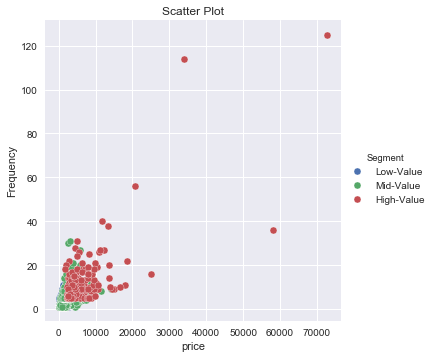

In [90]:
group=tx_user['Segment'].unique()
sns.pairplot(x_vars=['price'],y_vars=['Frequency'],data=tx_user, hue='Segment', size=5)
plt.title('Scatter Plot')
plt.show()

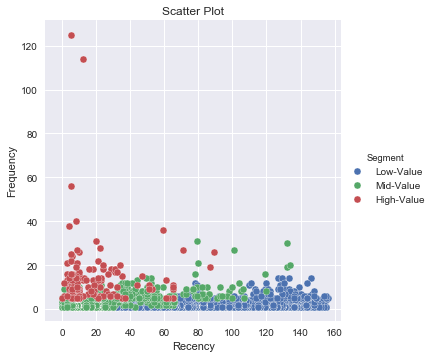

In [91]:
group=tx_user['Segment'].unique()
sns.pairplot(x_vars=['Recency'],y_vars=['Frequency'],data=tx_user, hue='Segment', size=5)
plt.title('Scatter Plot')
plt.show()

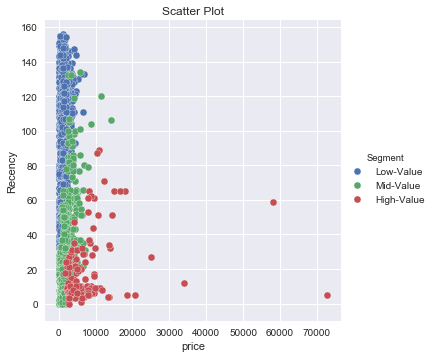

In [92]:
group=tx_user['Segment'].unique()
sns.pairplot(x_vars=['price'],y_vars=['Recency'],data=tx_user, hue='Segment', size=5)
plt.title('Scatter Plot')
plt.show()